# Step1. About this problem
   In this problem, we must create an algorithm to identify metastatic cancer in small image patches taken from larger digital
   pathology scans.<br>
     - Type of learning : Supervised learning<br>
     - Type of task     : Binary classification<br>
     - Data type        : Image<br>
   source: https://www.kaggle.com/c/histopathologic-cancer-detection/overview

# Step2. Exploratory Data Analysis (EDA)

In [1]:
from numpy.random import seed
seed(41)

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
tf.random.set_seed(41)

In [2]:
print(len(os.listdir('input/train')))
print(len(os.listdir('input/test')))

220025
57458


-> The Numbers of train and test data are above. Large-scale image data will be handled.

In [3]:
df_data = pd.read_csv('input/train_labels.csv')
print(df_data.shape)
df_data.head()

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

-> label=0 has a higher percentage than label=1.

In [5]:
#this function takes a sample of each class and displays that sample on one row. 

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, figsize=(4*figure_cols,4*len(categories))) # adjust size here
    
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

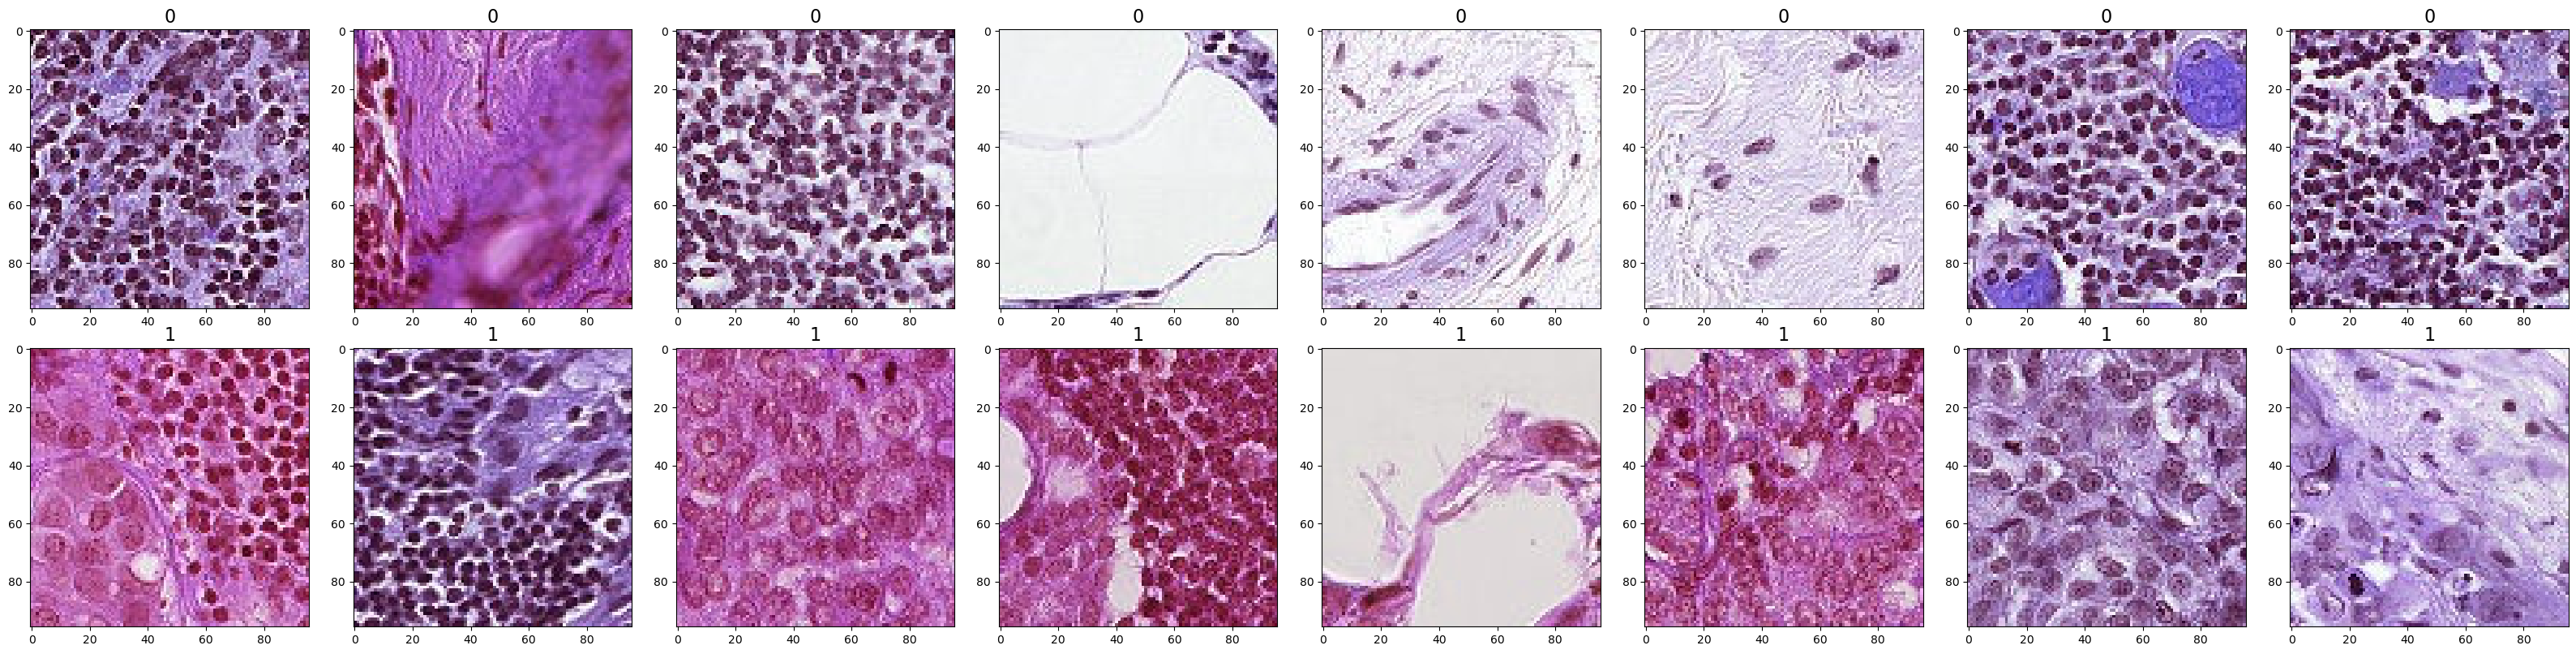

In [6]:
IMAGE_PATH = 'input/train/' 
draw_category_images('label',8, df_data, IMAGE_PATH)

-> Data with label 0 are placed in an upper row. Data with label 1 are placed in an lower row.

In [7]:
SAMPLE_SIZE=1000  

# Create the Train and Validation Sets
# I choose SAMPLE SIZE = 1000, because 
df_0=df_data[df_data['label']==0].sample(SAMPLE_SIZE,random_state=41)
df_1=df_data[df_data['label']==1].sample(SAMPLE_SIZE,random_state=41)

df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    1000
0    1000
Name: label, dtype: int64

-> I choose small number of sample, because the CNN model takes a long time to compute and the models with various parameters will be compared in the second half of this notebook.

In [8]:
#train-test split. stratify=y creates a balanced validation set.
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=41, stratify=y)

print(df_train.shape)
print(df_val.shape)

(1800, 2)
(200, 2)


In [9]:
# Create a new directory so that we will be using the ImageDataGenerator
base_dir='base_dir'
os.mkdir(base_dir)

# Create 2 folders inside 'base_dir':
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# create new folders inside train_dir
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

# create new folders inside val_dir
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [10]:
# check that the folders have been created
os.listdir('base_dir/train_dir')

['a_no_tumor_tissue', 'b_has_tumor_tissue']

In [11]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)

In [12]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])


# Transfer the train images
for image in train_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('input/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images
for image in val_list:
    
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('input/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [13]:
# check how many train images we have in each folder
print(len(os.listdir('base_dir/train_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/train_dir/b_has_tumor_tissue')))

900
900


In [14]:
# check how many val images we have in each folder
print(len(os.listdir('base_dir/val_dir/a_no_tumor_tissue')))
print(len(os.listdir('base_dir/val_dir/b_has_tumor_tissue')))

100
100


In [15]:
# Set up the generators
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = '../input/test'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [16]:
datagen = ImageDataGenerator(rescale=1.0/255)
IMAGE_SIZE=96

## Defines how image data is to be fed into the CNN.
train_gen = datagen.flow_from_directory(train_path,                             ## Data Storage Folder
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),    ## Pixels of data when pouring
                                        batch_size=train_batch_size,            ## Number of data to be poured at a time
                                        class_mode='categorical')                

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [17]:
train_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

-> The label is assigned the name of a folder in the directory specified in flow_from_directory.<br>
-> For example, if there are folders named "dog" and "cat" in the directory, the label will be [dog, cat].

In [18]:
train_gen.next()[0].shape

(10, 96, 96, 3)

-> 10 image data, 96x96 pixels x 3 colors

In [19]:
train_gen.next()[1]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

-> train_gen[1] is 10 One-hot vectors

C:\Users\User\anaconda3\Lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


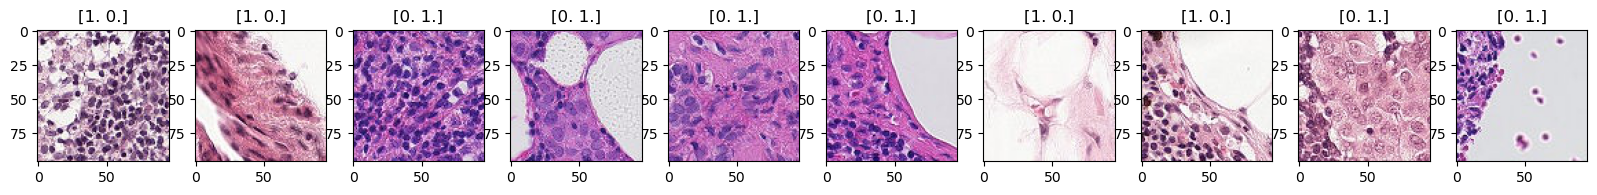

In [20]:
image, label = train_gen.next()

fig = plt.figure(figsize=(20, 20))
for i in range(10):
    fig.add_subplot(1, 10, i+1).set_title(label[i])
    plt.imshow(image[i])

-> train_gen is the comnination data of "image" and "label".

# Step3. Models
I tried various values of the following three parameters and compared the results.<br>
- 1.The number of Epoch.
- 2.The number of layer.
- 3.Drop out rate.

## Model1. Comparison of models at various epoch numbers

In [21]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model1 = Sequential()
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model1.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model1.add(MaxPooling2D(pool_size = pool_size)) 
model1.add(Dropout(dropout_conv))

model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model1.add(MaxPooling2D(pool_size = pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model1.add(MaxPooling2D(pool_size = pool_size))
model1.add(Dropout(dropout_conv))

model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(dropout_dense))
model1.add(Dense(2, activation = "softmax"))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 64)        0

In [22]:
model1.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)
                                                      
callbacks_list = [checkpoint, reduce_lr]
history1 = model1.fit_generator(train_gen, steps_per_epoch=train_steps, validation_data=val_gen,
                              validation_steps=val_steps, epochs=10, verbose=1, callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
180/180 [==============================] - 69s 384ms/step - loss: 0.6608 - accuracy: 0.5739 - val_loss: 0.5288 - val_accuracy: 0.8000
Epoch 2/10
180/180 [==============================] - 67s 374ms/step - loss: 0.5288 - accuracy: 0.7633 - val_loss: 0.4552 - val_accuracy: 0.8350
Epoch 3/10
180/180 [==============================] - 67s 374ms/step - loss: 0.5383 - accuracy: 0.7539 - val_loss: 0.4639 - val_accuracy: 0.8250
Epoch 4/10
180/180 [==============================] - 66s 366ms/step - loss: 0.5180 - accuracy: 0.7639 - val_loss: 0.4897 - val_accuracy: 0.7900
Epoch 5/10
180/180 [==============================] - 65s 363ms/step - loss: 0.5043 - accuracy: 0.7694 - val_loss: 0.4582 - val_accuracy: 0.8100
Epoch 6/10
180/180 [==============================] - 66s 367ms/step - loss: 0.4979 - accuracy: 0.7633 - val_loss: 0.4171 - val_accuracy: 0.8100
Epoch 7/10
180/180 [==============================] - 

In [23]:
# Here the best epoch will be used.

val_loss, val_acc = \
model1.evaluate_generator(test_gen, steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

Instructions for updating:
Please use Model.evaluate, which supports generators.
val_loss: 0.45571884512901306
val_acc: 0.8050000071525574


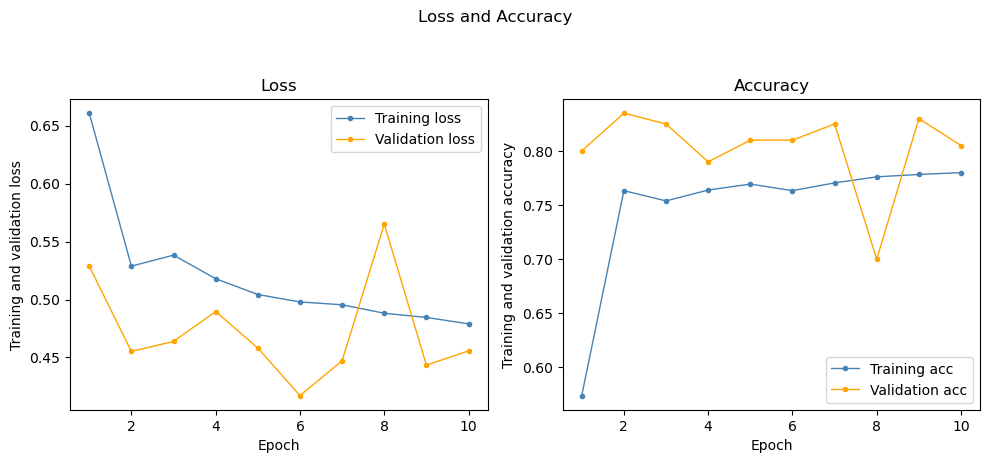

In [24]:
# display the loss and accuracy curves

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot
n_factor = range(1,11)

# Create subplots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Loss and Accuracy")

# Plot loss scores
ax[0, 0].set_title("Loss")
ax[0, 0].set_xlabel("Epoch")
ax[0, 0].set_ylabel("Training and validation loss")
ax[0, 0].plot(epochs, loss, marker=".", color="steelblue", lw=1, label="Training loss")
ax[0, 0].plot(epochs, val_loss, marker=".", color="orange", lw=1, label="Validation loss")
ax[0, 0].legend()

# Plot accuracy scores
ax[0, 1].set_title("Accuracy")
ax[0, 1].set_xlabel("Epoch")
ax[0, 1].set_ylabel("Training and validation accuracy")
ax[0, 1].plot(epochs, acc, marker=".", color="steelblue", lw=1, label="Training acc")
ax[0, 1].plot(epochs, val_acc, marker=".", color="orange", lw=1, label="Validation acc")
ax[0, 1].legend()

# Remove empty subplot
fig.delaxes(ax[1, 0])
fig.delaxes(ax[1, 1])

# Show the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

-> The epoch numbers 2, 6, 7 and 9 were a good result when both loss and accuracy were taken into account.<br>
-> The Epoch 8 appeared to be an outlier due to the small sample size.

## Model2. Comparison of models with varying middle layer numbers

In [25]:
def create_model(num_filters):
    
    kernel_size = (3,3)
    pool_size= (2,2)
    dropout_conv = 0.3
    dropout_dense = 0.3
    
    for i in range(num_filters):
        if i == 0:
            model = Sequential()
            model.add(Conv2D(32, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
            model.add(Conv2D(32, kernel_size, activation ='relu'))
            model.add(MaxPooling2D(pool_size = pool_size)) 
            model.add(Dropout(dropout_conv))

        else:
            model.add(Conv2D(32*pow(2,i), kernel_size, activation ='relu'))
            model.add(Conv2D(32*pow(2,i), kernel_size, activation ='relu'))
            model.add(MaxPooling2D(pool_size = pool_size))
            model.add(Dropout(dropout_conv))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(2, activation = "softmax"))

    #model.summary()
    
    return model

Number of middle layer = 0
-
Epoch 1/6
180/180 [==============================] - 46s 253ms/step - loss: 0.6450 - accuracy: 0.6333 - val_loss: 0.5216 - val_accuracy: 0.7750
Epoch 2/6
180/180 [==============================] - 45s 250ms/step - loss: 0.4902 - accuracy: 0.7828 - val_loss: 0.4969 - val_accuracy: 0.7350
Epoch 3/6
180/180 [==============================] - 45s 249ms/step - loss: 0.4599 - accuracy: 0.7950 - val_loss: 0.5225 - val_accuracy: 0.7300
Epoch 4/6
180/180 [==============================] - 39s 218ms/step - loss: 0.4119 - accuracy: 0.8333 - val_loss: 0.4420 - val_accuracy: 0.8050
Epoch 5/6
180/180 [==============================] - 20s 113ms/step - loss: 0.3591 - accuracy: 0.8539 - val_loss: 0.4935 - val_accuracy: 0.7600
Epoch 6/6
180/180 [==============================] - 21s 116ms/step - loss: 0.3091 - accuracy: 0.8872 - val_loss: 0.4604 - val_accuracy: 0.7750


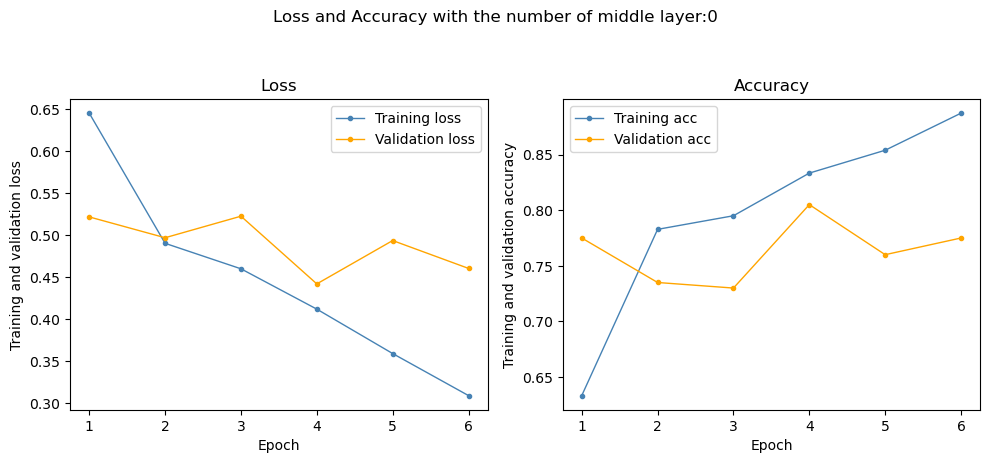

□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□
Number of middle layer = 1
-
Epoch 1/6
180/180 [==============================] - 25s 141ms/step - loss: 0.6797 - accuracy: 0.5672 - val_loss: 0.6287 - val_accuracy: 0.6800
Epoch 2/6
180/180 [==============================] - 29s 163ms/step - loss: 0.5503 - accuracy: 0.7300 - val_loss: 0.4658 - val_accuracy: 0.8200
Epoch 3/6
180/180 [==============================] - 29s 161ms/step - loss: 0.5200 - accuracy: 0.7572 - val_loss: 0.4705 - val_accuracy: 0.8250
Epoch 4/6
180/180 [==============================] - 29s 162ms/step - loss: 0.4920 - accuracy: 0.7739 - val_loss: 0.4533 - val_accuracy: 0.8250
Epoch 5/6
180/180 [==============================] - 29s 164ms/step - loss: 0.5041 - accuracy: 0.7706 - val_loss: 0.4513 - val_accuracy: 0.8300
Epoch 6/6
180/180 [==============================] - 29s 163ms/step - loss: 0.4784 - accuracy: 0.7900 - val_loss: 0.4995 - val_accuracy: 0.7600


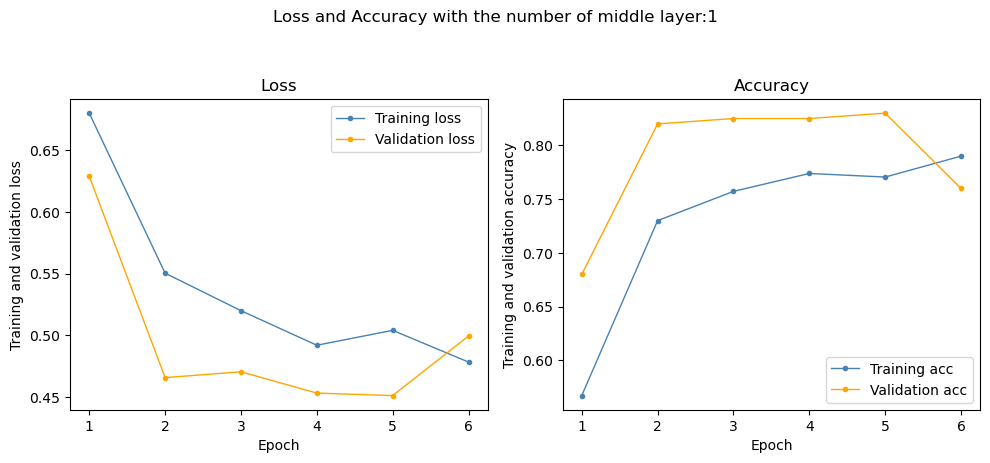

□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□
Number of middle layer = 2
-
Epoch 1/6
180/180 [==============================] - 33s 184ms/step - loss: 0.6985 - accuracy: 0.5072 - val_loss: 0.6899 - val_accuracy: 0.5150
Epoch 2/6
180/180 [==============================] - 35s 195ms/step - loss: 0.6440 - accuracy: 0.6161 - val_loss: 0.5944 - val_accuracy: 0.7050
Epoch 3/6
180/180 [==============================] - 36s 203ms/step - loss: 0.5560 - accuracy: 0.7422 - val_loss: 0.5718 - val_accuracy: 0.7350
Epoch 4/6
180/180 [==============================] - 36s 202ms/step - loss: 0.5235 - accuracy: 0.7567 - val_loss: 0.5207 - val_accuracy: 0.7900
Epoch 5/6
180/180 [==============================] - 37s 203ms/step - loss: 0.5101 - accuracy: 0.7622 - val_loss: 0.4615 - val_accuracy: 0.8250
Epoch 6/6
180/180 [==============================] - 37s 206ms/step - loss: 0.5013 - accuracy: 0.7739 - val_loss: 0.4628 - val_accuracy: 0.8250


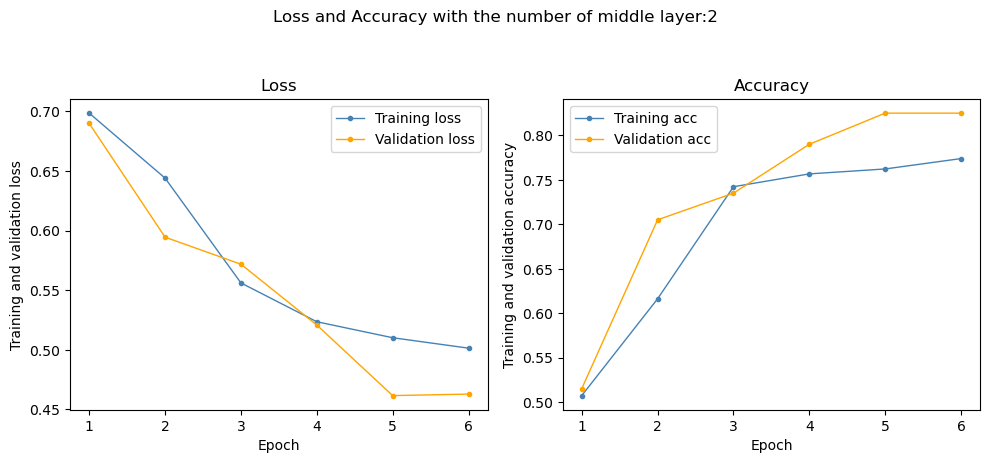

□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□


In [26]:
  
for i in range(1,4):
    print("Number of middle layer =",i-1)
    print("-")
    model2 = create_model(i)
    model2.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    filepath = "model.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)
    callbacks_list = [checkpoint, reduce_lr]
    history2 = model2.fit_generator(train_gen, steps_per_epoch=train_steps, validation_data=val_gen,
                                    validation_steps=val_steps, epochs=6, verbose=1, callbacks=callbacks_list)
    
    val_loss, val_acc = \
    model2.evaluate_generator(test_gen, steps=len(df_val))
    #print('val_loss:', val_loss)
    #print('val_acc:', val_acc)

    # display the loss and accuracy curves
    acc = history2.history['accuracy']
    val_acc = history2.history['val_accuracy']
    loss = history2.history['loss']
    val_loss = history2.history['val_loss']
    epochs = range(1, len(acc) + 1)
    n_factor = range(1,11)

    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    title = f"Loss and Accuracy with the number of middle layer:{i-1}"
    fig.suptitle(title)

    ax[0, 0].set_title("Loss")
    ax[0, 0].set_xlabel("Epoch")
    ax[0, 0].set_ylabel("Training and validation loss")
    ax[0, 0].plot(epochs, loss, marker=".", color="steelblue", lw=1, label="Training loss")
    ax[0, 0].plot(epochs, val_loss, marker=".", color="orange", lw=1, label="Validation loss")
    ax[0, 0].legend()

    ax[0, 1].set_title("Accuracy")
    ax[0, 1].set_xlabel("Epoch")
    ax[0, 1].set_ylabel("Training and validation accuracy")
    ax[0, 1].plot(epochs, acc, marker=".", color="steelblue", lw=1, label="Training acc")
    ax[0, 1].plot(epochs, val_acc, marker=".", color="orange", lw=1, label="Validation acc")
    ax[0, 1].legend()

    fig.delaxes(ax[1, 0])
    fig.delaxes(ax[1, 1])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print("□"*60)

-> Highest accuracy is epoch = 5 with the number of middle layter = 1 and the number of middle layer = 1 became the most stable.<br>
-> The result of the number of middle layer = 2 was not bad.<br>
-> The number of middle layer = 0 appeared to have unstable validation results due to the lack of an intermediate layer 

## Model3. Comparison of models at various drop out rate

In [27]:
def create_model_drop(dropout_rate):
    
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = dropout_rate
    dropout_dense = dropout_rate
    
    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))
    
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(2, activation = "softmax"))

    #model.summary()
    
    return model

Drop out rate = 0.0
Epoch 1/6
180/180 [==============================] - 72s 400ms/step - loss: 0.6323 - accuracy: 0.6417 - val_loss: 0.6261 - val_accuracy: 0.6900
Epoch 2/6
180/180 [==============================] - 71s 395ms/step - loss: 0.5397 - accuracy: 0.7500 - val_loss: 0.4934 - val_accuracy: 0.8100
Epoch 3/6
180/180 [==============================] - 72s 397ms/step - loss: 0.5229 - accuracy: 0.7450 - val_loss: 0.5011 - val_accuracy: 0.7850
Epoch 4/6
180/180 [==============================] - 71s 394ms/step - loss: 0.5048 - accuracy: 0.7617 - val_loss: 0.4853 - val_accuracy: 0.7950
Epoch 5/6
180/180 [==============================] - 71s 395ms/step - loss: 0.4905 - accuracy: 0.7728 - val_loss: 0.4822 - val_accuracy: 0.8100
Epoch 6/6
180/180 [==============================] - 71s 395ms/step - loss: 0.4915 - accuracy: 0.7750 - val_loss: 0.4996 - val_accuracy: 0.7900


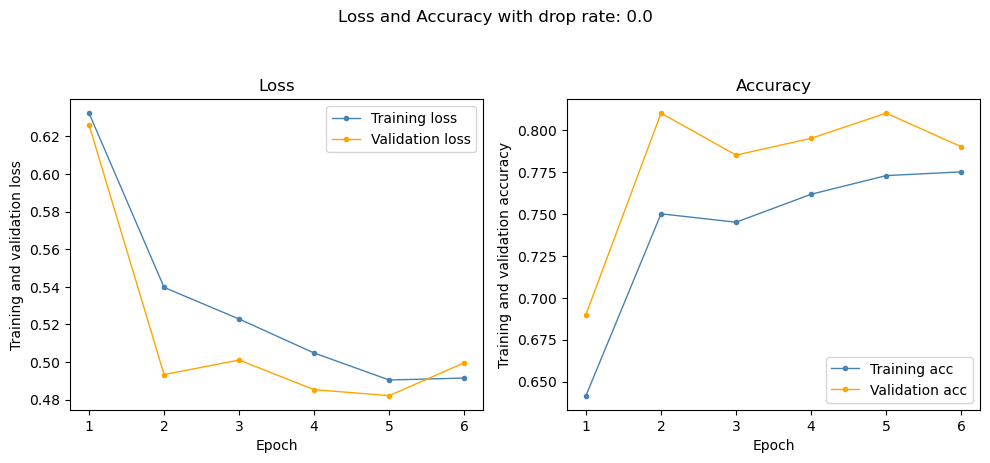

□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□
Drop out rate = 0.1
Epoch 1/6
180/180 [==============================] - 71s 393ms/step - loss: 0.6616 - accuracy: 0.5956 - val_loss: 0.5726 - val_accuracy: 0.7250
Epoch 2/6
180/180 [==============================] - 71s 397ms/step - loss: 0.5440 - accuracy: 0.7411 - val_loss: 0.4382 - val_accuracy: 0.8200
Epoch 3/6
180/180 [==============================] - 71s 396ms/step - loss: 0.5231 - accuracy: 0.7511 - val_loss: 0.4348 - val_accuracy: 0.8450
Epoch 4/6
180/180 [==============================] - 71s 397ms/step - loss: 0.5011 - accuracy: 0.7744 - val_loss: 0.4694 - val_accuracy: 0.8300
Epoch 5/6
180/180 [==============================] - 71s 395ms/step - loss: 0.4952 - accuracy: 0.7850 - val_loss: 0.4144 - val_accuracy: 0.8500
Epoch 6/6
180/180 [==============================] - 71s 396ms/step - loss: 0.4847 - accuracy: 0.7711 - val_loss: 0.4146 - val_accuracy: 0.8350


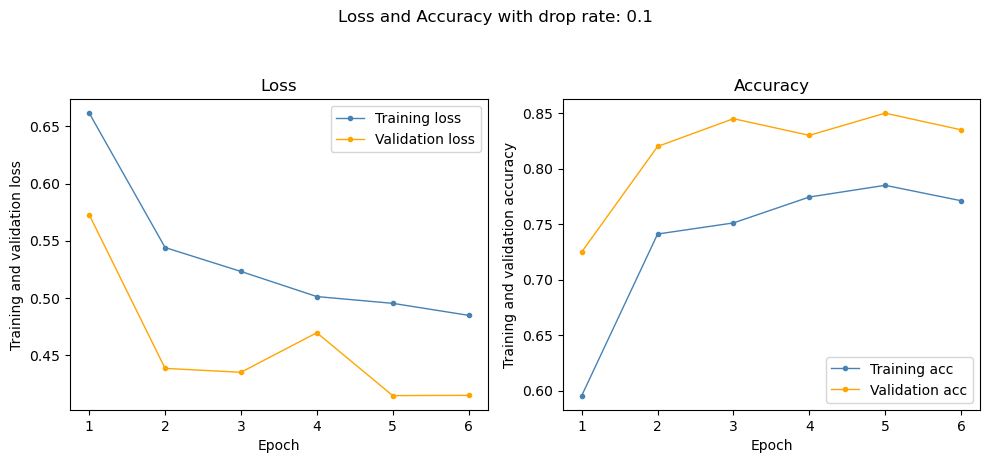

□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□
Drop out rate = 0.2
Epoch 1/6
180/180 [==============================] - 70s 390ms/step - loss: 0.6730 - accuracy: 0.5683 - val_loss: 0.6191 - val_accuracy: 0.6700
Epoch 2/6
180/180 [==============================] - 71s 396ms/step - loss: 0.5716 - accuracy: 0.7122 - val_loss: 0.4900 - val_accuracy: 0.7500
Epoch 3/6
180/180 [==============================] - 70s 392ms/step - loss: 0.5283 - accuracy: 0.7478 - val_loss: 0.5581 - val_accuracy: 0.6550
Epoch 4/6
180/180 [==============================] - 70s 390ms/step - loss: 0.5113 - accuracy: 0.7689 - val_loss: 0.4985 - val_accuracy: 0.7800
Epoch 5/6
180/180 [==============================] - 70s 389ms/step - loss: 0.5111 - accuracy: 0.7672 - val_loss: 0.4938 - val_accuracy: 0.7950
Epoch 6/6
180/180 [==============================] - 70s 391ms/step - loss: 0.4939 - accuracy: 0.7739 - val_loss: 0.4415 - val_accuracy: 0.8100


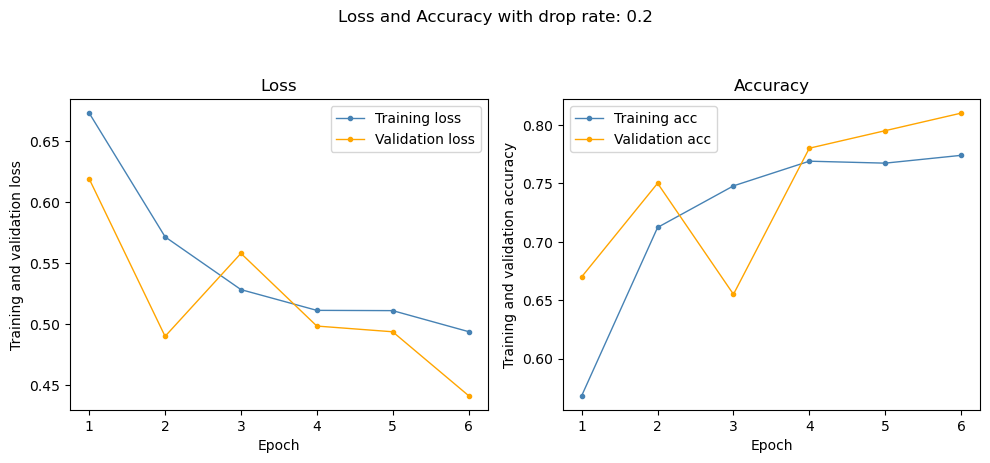

□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□
Drop out rate = 0.30000000000000004
Epoch 1/6
180/180 [==============================] - 70s 391ms/step - loss: 0.6879 - accuracy: 0.5483 - val_loss: 0.6397 - val_accuracy: 0.6100
Epoch 2/6
180/180 [==============================] - 71s 394ms/step - loss: 0.5977 - accuracy: 0.6917 - val_loss: 0.5749 - val_accuracy: 0.7150
Epoch 3/6
180/180 [==============================] - 70s 388ms/step - loss: 0.5419 - accuracy: 0.7383 - val_loss: 0.4714 - val_accuracy: 0.8100
Epoch 4/6
180/180 [==============================] - 70s 390ms/step - loss: 0.5177 - accuracy: 0.7661 - val_loss: 0.4398 - val_accuracy: 0.8250
Epoch 5/6
180/180 [==============================] - 70s 389ms/step - loss: 0.4993 - accuracy: 0.7722 - val_loss: 0.4535 - val_accuracy: 0.8200
Epoch 6/6
180/180 [==============================] - 70s 390ms/step - loss: 0.4936 - accuracy: 0.7761 - val_loss: 0.4216 - val_accuracy: 0.8350


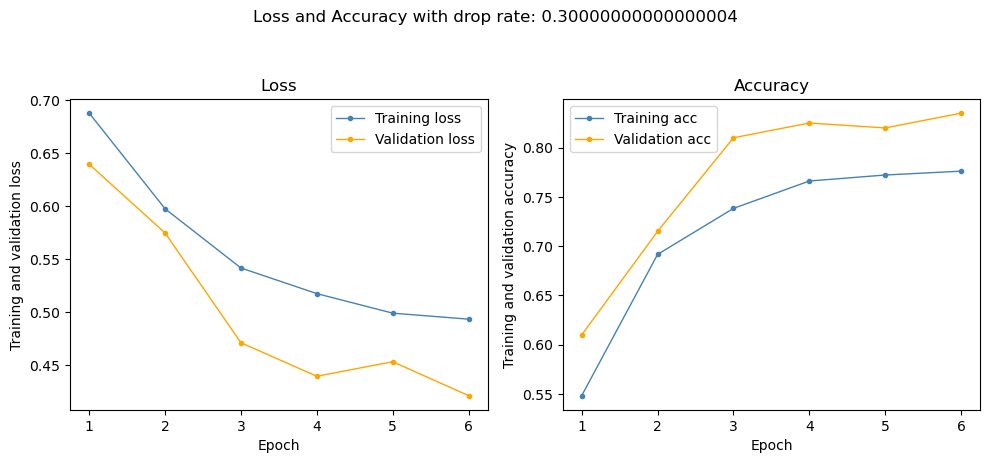

□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□
Drop out rate = 0.4
Epoch 1/6
180/180 [==============================] - 70s 390ms/step - loss: 0.6998 - accuracy: 0.5039 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/6
180/180 [==============================] - 71s 397ms/step - loss: 0.6611 - accuracy: 0.5867 - val_loss: 0.5642 - val_accuracy: 0.7850
Epoch 3/6
180/180 [==============================] - 72s 402ms/step - loss: 0.5792 - accuracy: 0.7161 - val_loss: 0.5216 - val_accuracy: 0.8200
Epoch 4/6
180/180 [==============================] - 72s 402ms/step - loss: 0.5346 - accuracy: 0.7506 - val_loss: 0.4940 - val_accuracy: 0.7900
Epoch 5/6
180/180 [==============================] - 70s 389ms/step - loss: 0.5121 - accuracy: 0.7633 - val_loss: 0.4829 - val_accuracy: 0.7900
Epoch 6/6
180/180 [==============================] - 70s 389ms/step - loss: 0.5128 - accuracy: 0.7617 - val_loss: 0.4559 - val_accuracy: 0.8200


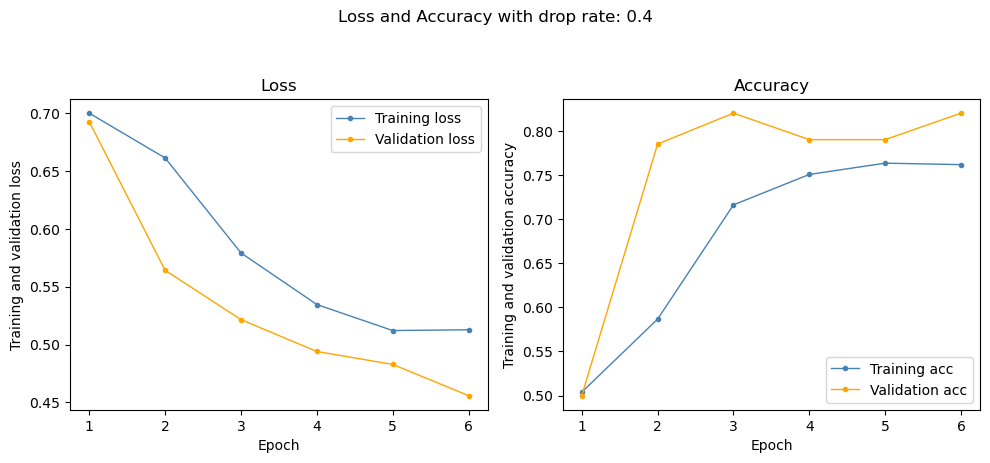

□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□□


In [28]:
for i in range(0,5):
    print("Drop out rate =", 0.1*i)
    model3 = create_model_drop(0.1*i)
    model3.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    
    filepath = "model.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, verbose=1, mode='max', min_lr=0.00001)
    callbacks_list = [checkpoint, reduce_lr]
    history3 = model3.fit_generator(train_gen, steps_per_epoch=train_steps, validation_data=val_gen,
                                  validation_steps=val_steps, epochs=6, verbose=1, callbacks=callbacks_list)
    
    val_loss, val_acc = \
    model3.evaluate_generator(test_gen, steps=len(df_val))

    #print('val_loss:', val_loss)
    #print('val_acc:', val_acc)
    
    # display the loss and accuracy curves
    acc = history3.history['accuracy']
    val_acc = history3.history['val_accuracy']
    loss = history3.history['loss']
    val_loss = history3.history['val_loss']
    epochs = range(1, len(acc) + 1)
    n_factor = range(1,11)

    fig, ax = plt.subplots(2, 2, figsize=(10, 8))
    #fig.suptitle("Loss and Accuracy with drop rate:", 0.1*i)
    title = f"Loss and Accuracy with drop rate: {0.1*i}"
    fig.suptitle(title)

    ax[0, 0].set_title("Loss")
    ax[0, 0].set_xlabel("Epoch")
    ax[0, 0].set_ylabel("Training and validation loss")
    ax[0, 0].plot(epochs, loss, marker=".", color="steelblue", lw=1, label="Training loss")
    ax[0, 0].plot(epochs, val_loss, marker=".", color="orange", lw=1, label="Validation loss")
    ax[0, 0].legend()

    ax[0, 1].set_title("Accuracy")
    ax[0, 1].set_xlabel("Epoch")
    ax[0, 1].set_ylabel("Training and validation accuracy")
    ax[0, 1].plot(epochs, acc, marker=".", color="steelblue", lw=1, label="Training acc")
    ax[0, 1].plot(epochs, val_acc, marker=".", color="orange", lw=1, label="Validation acc")
    ax[0, 1].legend()

    fig.delaxes(ax[1, 0])
    fig.delaxes(ax[1, 1])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    print("□"*60)

-> While none of the results stand out significantly, the highest recorded accuracy is 0.1 and the results of drop out rate = 0.1 is seemd to most stable.<br>
-> However, the results of drop out rates = 0.3 and 0.4 were not bad.

## Model4. Submission model
 Considering the results of above trial, I choose following parameters for submission:<br>
 -The number of epoch : 8<br>
 -The number of middle layer : 2<br>
 -The drop out rate : 0.4<br>
 The result of epoch 8 in the model1 was not good. However, it appeared to be an outlier due to the small sample size. So I tried again to check it.

In [29]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.4
dropout_dense = 0.4

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 92, 92, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 42, 42, 64)        36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 21, 21, 64)       

In [30]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                                                      
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, validation_data=val_gen,
                              validation_steps=val_steps, epochs=8, verbose=1,callbacks=callbacks_list)

val_loss, val_acc = \
model.evaluate_generator(test_gen, steps=len(df_val))

#print('val_loss:', val_loss)
#print('val_acc:', val_acc)

Epoch 1/8
180/180 [==============================] - 36s 199ms/step - loss: 0.6952 - accuracy: 0.5033 - val_loss: 0.6860 - val_accuracy: 0.5050
Epoch 2/8
180/180 [==============================] - 38s 209ms/step - loss: 0.5977 - accuracy: 0.6889 - val_loss: 0.4500 - val_accuracy: 0.8400
Epoch 3/8
180/180 [==============================] - 37s 208ms/step - loss: 0.5189 - accuracy: 0.7589 - val_loss: 0.4477 - val_accuracy: 0.8400
Epoch 4/8
180/180 [==============================] - 36s 197ms/step - loss: 0.5030 - accuracy: 0.7706 - val_loss: 0.4307 - val_accuracy: 0.8400
Epoch 5/8
180/180 [==============================] - 35s 196ms/step - loss: 0.4933 - accuracy: 0.7806 - val_loss: 0.4440 - val_accuracy: 0.8200
Epoch 6/8
180/180 [==============================] - 36s 200ms/step - loss: 0.4879 - accuracy: 0.7800 - val_loss: 0.4564 - val_accuracy: 0.7900
Epoch 7/8
180/180 [==============================] - 35s 196ms/step - loss: 0.4952 - accuracy: 0.7828 - val_loss: 0.5100 - val_accuracy:

In [31]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

Instructions for updating:
Please use Model.predict, which supports generators.
200/200 [==============================] - 4s 19ms/step


In [32]:
predictions.shape

(200, 2)

In [33]:
# This is how to check what index keras has internally assigned to each class. 
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [34]:
# Put the predictions into a dataframe.
# The columns need to be ordered to match the output of the previous cell

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])
df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.759870,0.240130
1,0.144026,0.855974
2,0.596716,0.403284
3,0.644491,0.355509
4,0.774001,0.225999


In [35]:
# Get the true labels
y_true = test_gen.classes

# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor_tissue']

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, y_pred)

0.9088

In [37]:
# Get the labels of the test images.

test_labels = test_gen.classes
test_labels.shape

(200,)

In [38]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
# Print the label associated with each class
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

In [39]:
# Delete base_dir and it's sub folders to free up disk space.
shutil.rmtree('base_dir')


#[CREATE A TEST FOLDER DIRECTORY STRUCTURE]
# We will be feeding test images from a folder into predict_generator().
# Keras requires that the path should point to a folder containing images and not
# to the images themselves. That is why we are creating a folder (test_images) 
# inside another folder (test_dir).

# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)
# check that the directory we created exists
os.listdir('test_dir')

['test_images']

In [40]:
# Transfer the test images into image_dir

test_list = os.listdir('input/test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join('input/test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)
# check that the images are now in the test_images
# Should now be 57458 images in the test_images folder

len(os.listdir('test_dir/test_images'))

57458

In [41]:
test_path ='test_dir'

# Here we change the path to point to the test_images folder.
test_gen = datagen.flow_from_directory(test_path, target_size=(IMAGE_SIZE,IMAGE_SIZE), 
                                       batch_size=1, class_mode='categorical',shuffle=False)

Found 57458 images belonging to 1 classes.


In [42]:
num_test_images = 57458
predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)

57458/57458 [==============================] - 1106s 19ms/step


In [43]:
# Are the number of predictions correct?
# Should be 57458.

len(predictions)

57458

In [44]:
# Put the predictions into a dataframe

df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])
df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.320153,0.679847
1,0.533998,0.466002
2,0.455073,0.544927
3,0.805687,0.194313
4,0.883741,0.116259


In [45]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames
df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names
0,0.320153,0.679847,test_images\00006537328c33e284c973d7b39d340809...
1,0.533998,0.466002,test_images\0000ec92553fda4ce39889f9226ace43ca...
2,0.455073,0.544927,test_images\00024a6dee61f12f7856b0fc6be20bc7a4...
3,0.805687,0.194313,test_images\000253dfaa0be9d0d100283b22284ab2f6...
4,0.883741,0.116259,test_images\000270442cc15af719583a8172c87cd2bd...


In [46]:
# Create an id column

# A file name now has this format: 
# test_images/00006537328c33e284c973d7b39d340809f7271b.tif

# This function will extract the id:
# 00006537328c33e284c973d7b39d340809f7271b

def extract_id(x):
    
    # split into a list
    a = x.split('\\')
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)
df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names,id
0,0.320153,0.679847,test_images\00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,0.533998,0.466002,test_images\0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.455073,0.544927,test_images\00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.805687,0.194313,test_images\000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.883741,0.116259,test_images\000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [47]:
# Get the predicted labels.
# We were asked to predict a probability that the image has tumor tissue
y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']

In [48]:
submission = pd.DataFrame({'id':image_id, 'label':y_pred, }).set_index('id')
submission.to_csv('submission.csv', columns=['label']) 
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.679847
0000ec92553fda4ce39889f9226ace43cae3364e,0.466002
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.544927
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.194313
000270442cc15af719583a8172c87cd2bd9c7746,0.116259


In [49]:
# Delete the test_dir directory we created to prevent.
shutil.rmtree('test_dir')

## Conclusion
I tried various values of the following three parameters and compared the results.<br>
- 1.The number of Epoch<br>
The epoch numbers 2, 6, 7 and 9 were a good result when both loss and accuracy were taken into account.<br>
The Epoch 8 appeared to be an outlier due to the small sample size.<br><br>
- 2.The number of layer<br>
Highest accuracy is epoch = 5 with the number of middle layter = 1 and the number of middle layer = 1 became the most stable.<br>
The result of the number of middle layer = 2 was not bad.<br>
The number of middle layer = 0 appeared to have unstable validation results due to the lack of an intermediate layer<br><br>
- 3.Drop out rate<br>
While none of the results stand out significantly, the highest recorded accuracy is drop out rate = 0.1 and <br>
the results of drop out rate = 0.1 is seemd to most stable.<br>
However, the results of drop out rates = 0.3 and 0.4 were not bad.<br><br>

I built the model with following parameters for submission.The result of epoch 8 in the model1 was not good. However, it appeared to be an outlier due to the small sample size. So I tried again to check it.<br>
- The number of epoch : 8<br>
- The number of middle layer : 2<br>
- The drop out rate : 0.4<br><br>

The result of this model was as follows:
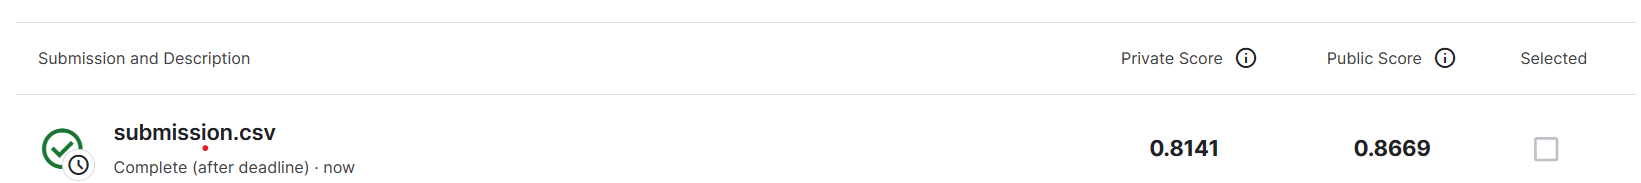<br>

While the sample size was limited to 2000 for testing purposes across various parameters, the resulting model demonstrated reasonable discriminative power. Obtaining better results would be feasible by using a sufficiently large sample size.